In [536]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
from gym import spaces
import torch.nn.functional as F

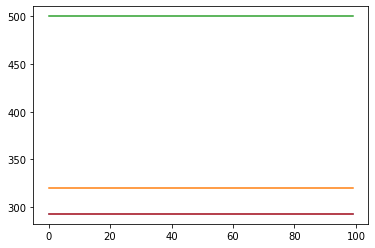

293.0

In [392]:
class Env():
    def __init__(self,**kwargs):
        self.params=kwargs
    
    def __getattribute__(self,attr):
        try:
            return super().__getattribute__(attr)
        except AttributeError as e:
            if attr in self.params:
                return self.params[attr]
            else:
                raise e
                
class HeatEnv(Env):
    HEAT=1
    COOL=0
    
    def __init__(self,**kwargs):#env_heat=293,ini_heat=293,max_heat=500,target_index=20,gradient_length=100,recorder_length=100,max_steps=1000
        kwargs={**dict(env_heat=293,ini_heat=293,max_heat=500,target_index=20,
                       gradient_length=100,recorder_length=100,max_steps=1000,target_temp=None),
               **kwargs
               }
        super().__init__(**kwargs)      
        self.reset()
        if self.target_temp is not None:
            self.set_target(self.target_temp)
        else:
            self.set_target(self.ini_heat)
    
    def copy(self):
        return self.__class__(**self.params)
        
    def reset(self):
        self.data=np.ones(self.gradient_length,dtype=float)*self.ini_heat
        return self.observe()

    def _transfer(self):
        diff=self.data[1:]-self.data[:-1]
        self.data[:-1]+=diff*0.1
        self.data[1:]-=diff*0.1
        self.data[:]-=(self.data-self.ini_heat)*0.00001
        
    def heat(self):
        self.data[0]+=(self.max_heat-self.data[0])*0.05
        self._transfer()

    def cool(self):
        self._transfer()
        
    def step(self,action):
        if action==self.HEAT:
            self.heat()
        else:
            self.cool()
                
        return self.observe()
    
    def observe(self):
        return self.data[self.target_index]
    
    def set_target(self,temp):
        if temp>self.max_heat:
            temp=self.max_heat
            
        if temp<self.env_heat:
            temp=self.env_heat
            
        self.target_temp=temp
        
    def plot(self):
        ih=np.ones(len(self.data))*self.ini_heat
        plt.plot(ih)
        plt.plot(np.ones_like(ih)*self.target_temp)
        plt.plot(np.ones_like(ih)*self.max_heat)
        plt.plot(self.data)
        plt.show()
        plt.close()

env=HeatEnv(target_temp=320)
#env.set_target(320)
for i in range(2000):
    s=env.step(env.HEAT)
env.reset()
env.plot()
env.reset()

In [543]:
class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, index):
        d = self.data[index]
        x = d[0]
        y = d[1]
        env = d[2]
        return x, y,env

    def __len__(self):
        return len(self.data)
    
    def collate(batch):
        return torch.tensor([dp[0] for dp in batch]).float(), torch.tensor([dp[1] for dp in batch]).float(), [dp[2] for dp in batch]
    
class NNTempModel(pl.LightningModule):
    def __init__(self,env,backtime=100):
        super().__init__()
        self.backtime=100
        self.net=nn.Sequential(
            nn.Linear(self.backtime,128),
            nn.ELU(),
            nn.Linear(128,128),
            nn.Linear(128,1),
            nn.Sigmoid()
        )
        
        self.lr=0.001
        self.batch_size=2
        self.env=env
        
    
    def forward(self,x):
        return self.net(x)
    
    def training_step(self, batch, nb_batch):
        #print(batch)
        x=batch[0]
        y=batch[1]
        envs=batch[2]
        y_hat=x
        for i in range(200):
            actions=self(y_hat)
            for i,env in enumerate(envs):
                env.data=y_hat[i]
            #y_hat[:,1]=y_hat[:,-1]
            for i,env in enumerate(envs):
                env.step(actions[i])
                #y_hat[i,0]=env.observe()
        envs[0].plot()
        loss=(y_hat-y[:, None]).abs().sum(1)
        print(loss)
        return OrderedDict({'loss': loss})

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer"""
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return [optimizer]
    
    def __dataloader(self) -> DataLoader:
        """Initialize the Replay  dataset used for retrieving experiences"""
        data=[]
        targets=np.random.rand(100)*30+300
        for i in range(100):
            env=self.env.copy()
            env.set_target(targets[i])
            data.append([[env.observe()]*self.backtime,targets[i],env])
        dataset = MyDataset(data)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.batch_size,
            sampler=None,
            collate_fn=MyDataset.collate
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self.__dataloader()
    
model=NNTempModel(env)
trainer = pl.Trainer(
    gpus=1,
    accelerator='dp',
    #val_check_interval=100,
)

trainer.fit(model)

SyntaxError: EOF while scanning triple-quoted string literal (<ipython-input-543-be2288ff01f7>, line 63)

In [690]:
class MyDataset(torch.utils.data.IterableDataset):
    def __init__(self, data_call,n):
        self.data_call=data_call
        self.n=n
    
    def __iter__(self):
        def gen():
            for i in range(self.n):
                print(i," "*10,end="\r")
                for d in self.data_call():
                    yield d
        return gen()


class STModel(pl.LightningModule):
    def __init__(self,n_actions,obs_size=100,batch_size=16,hidden_size=512):
        super().__init__()
        
        self.net=nn.Sequential(
        nn.Linear(obs_size, hidden_size),
        nn.ELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ELU(),
        nn.Linear(hidden_size, hidden_size),
        nn.ELU(),
        nn.Linear(hidden_size, n_actions),
        nn.Sigmoid()
        )
        
        self.obs_size=obs_size
        self.batch_size=batch_size
        self.lr=0.001
        
    def forward(self,x):
        return self.net(x)
    
    @torch.no_grad()
    def generate_batch(self,n,max_prerun=3000,max_eval_delay=1000,**kwargs):
        env=HeatEnv(**kwargs)
        preobs=deque([env.observe()]*self.obs_size,maxlen=self.obs_size)
        
        stored_preobs=[]
        stored_actions=[]
        for i in range(np.random.randint(200+self.batch_size,max_prerun+1)):
            stored_preobs.append(np.array(preobs))
            action=self(torch.tensor(preobs,device=self.device).float())
            action=action.argmax().item()
            stored_actions.append(action)
            env.step(action)
            preobs.append(env.observe())
        
        stored_preobs=np.array(stored_preobs,dtype=np.float32)
        stored_actions=np.array(stored_actions)
        samples=np.random.choice(np.arange(200,len(stored_preobs)),n)
        
        obs=stored_preobs[samples]
        act=stored_actions[samples]

        target_idx=samples+np.random.randint(0,max_eval_delay,n)
        target_idx[target_idx>=stored_preobs.shape[0]]=stored_preobs.shape[0]-1
        target_obs=stored_preobs[target_idx]
        errors=target_obs-env.target_temp
        errors=errors.sum(1)
        #print(errors)
        errors=errors/max(20,np.abs(errors).max())
        #print(errors)
        change=act-errors
        change[change<0]=0
        change[change>1]=1
        
        new_act=np.zeros((n,2),dtype=np.float32)
        new_act[:,0]=1-change
        new_act[:,1]=change
        
        return [[obs[i],new_act[i],samples[i]] for i in range(n)]
    
    def training_step(self, batch, nb_batch):
        x=batch[0]
        y=batch[1]
        y_hat=self(x)
        #print(y)
        #print(y_hat)

        loss = F.l1_loss(y_hat, y)
        #print(batch[2])
        self.log('train_loss', loss,"sample_min",batch[2].min(),"sample_max",batch[2].max())
        #print(x.mean(),y_hat.argmax(1).float().mean(),y.argmax(1).float().mean(),loss)
        #print(y.argmax(1))
        return loss

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer"""
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        dataset = MyDataset(lambda:self.generate_batch(n=100,target_temp=320),200)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.batch_size,
       #     sampler=None,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self.__dataloader()
        
        
model=STModel(2)
#for x,y in model.generate_batch(n=10,target_temp=320):
#    print(x,y)

In [ ]:
trainer = pl.Trainer(
    gpus=1,
    #accelerator='dp',
    #val_check_interval=100,
    max_epochs=100,
    callbacks=[PrintCallback()],
)

trainer.fit(model)

,train_loss_step,train_loss_epoch,train_loss
0,0.5,0.500026,0.5
1,0.5,0.500000,0.5
2,0.5,0.500000,0.5


In [688]:
env.reset()
d = [env.observe()]*100
for i in range(8000):
    action=model(torch.tensor(d[-100:]).float()).argmax().item()
    env.step(action)
    d.append(env.observe())

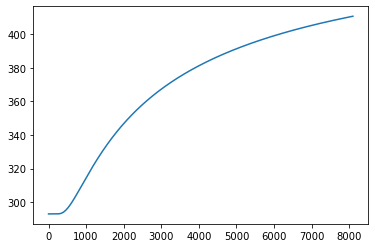

In [689]:
plt.plot(d)

In [656]:
from IPython.core.display import clear_output
import pandas as pd
import copy
def unwrap(x):
  if isinstance(x,torch.Tensor):
    return x.item()
  return x

class PrintCallback(pl.Callback):
  def __init__(self):
    self.metrics = []
    self.cols=[]
  def on_epoch_end(self,trainer,pl_module):
    clear_output(wait=True)
    metrics_dict = copy.deepcopy(trainer.callback_metrics)
    for c in metrics_dict:
        if c not in self.cols:
            self.cols.append(c)
    metrics_dict = {k:unwrap(v) for k,v in metrics_dict.items()}
    self.metrics.append(metrics_dict)
    del metrics_dict
    
    #column-names should be modified as per your usage
    metrics_df = pd.DataFrame.from_records(self.metrics,
                                           columns=self.cols)
    display(metrics_df)

In [345]:
import gym
class HeatEnvGym(gym.Env):
    def __init__(self,observation_memory=100,**kwargs):
        super().__init__()
        self.he=HeatEnv(**kwargs)
        self.observation_memory=deque([self.he.observe()]*observation_memory,maxlen=observation_memory)
        self.action_space = spaces.Discrete(2)
        self.observation_space = spaces.Box(low=0, high=self.he.max_heat, shape=(observation_memory,1), dtype=np.float)
        self.reset()
        
    def reset(self):
        self.he.reset()
        self.nsteps=0
        for i in range(len(self.observation_memory)):
            self.observation_memory.append(self.he.observe())
        return np.array(self.observation_memory)
    
    def step(self, action):
        #print(action)
        self.nsteps+=1
        self.he.step(action)
        self.observation_memory.append(self.he.observe())
            
        obs = np.array(self.observation_memory)
        reward = -np.abs(obs-self.he.target_temp).mean()
        done=self.nsteps>300
#        if done:
#            self.render()
        return obs, reward, done, {}
        

In [346]:
class ReplayBuffer:
    """
    Replay Buffer for storing past experiences allowing the agent to learn from them
    >>> ReplayBuffer(5)  # doctest: +ELLIPSIS
    <...reinforce_learn_Qnet.ReplayBuffer object at ...>
    """

    def __init__(self, capacity: int) -> None:
        """
        Args:
            capacity: size of the buffer
        """
        self.buffer = deque(maxlen=capacity)

    def __len__(self) -> int:
        return len(self.buffer)

    def append(self, experience: Experience) -> None:
        """
        Add experience to the buffer
        Args:
            experience: tuple (state, action, reward, done, new_state)
        """
        self.buffer.append(experience)

    def sample(self, batch_size: int) -> Tuple:
        indices = np.random.choice(len(self.buffer), batch_size, replace=False)
        states, actions, rewards, dones, next_states = zip(*[self.buffer[idx] for idx in indices])
        #print(np.array(indices).shape)
        return (
            np.array(states),
            np.array(actions),
            np.array(rewards, dtype=np.float32),
            np.array(dones, dtype=np.bool),
            np.array(next_states),
        )

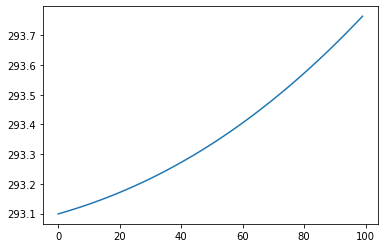

In [357]:
class Agent():
    def __init__(self,env,replay_size=1000):
        self.replay_buffer = ReplayBuffer(replay_size)
        self.env = env
        self.reset()
    
    def reset(self):
        self.state = self.env.reset()
       
    def get_action(self, net: nn.Module, epsilon: float, device: str) -> int:
        """
        Using the given network, decide what action to carry out
        using an epsilon-greedy policy
        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device
        Returns:
            action
        """
        if np.random.random() < epsilon:
            action = self.env.action_space.sample()
        else:
            state = torch.tensor([self.state])

            if device not in ['cpu']:
                state = state.cuda(device)

            q_values = net(state)
            _, action = torch.max(q_values, dim=1)
            action = int(action.item())

        return action
    
    @torch.no_grad()
    def play_step(self, net: nn.Module, epsilon: float = 0.0, device: str = 'cpu') -> Tuple[float, bool]:
        """
        Carries out a single interaction step between the agent and the environment
        Args:
            net: DQN network
            epsilon: value to determine likelihood of taking a random action
            device: current device
        Returns:
            reward, done
        """

        action = self.get_action(net, epsilon, device)

        # do step in the environment
       # print(action)
        new_state, reward, done, _ = self.env.step(action)
        #print(reward,done)
        exp = Experience(self.state, action, reward, done, new_state)

        self.replay_buffer.append(exp)

        self.state = new_state
        if done:
            self.reset()
        return reward, done
    
agent=Agent(HeatEnvGym(observation_memory=100,target_temp=320))
for i in range(300):
    s=agent.play_step(lambda s:torch.rand(2)[None,:])
plt.plot(agent.env.observation_memory)

In [369]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.optimizer import Optimizer
from torch.utils.data import DataLoader
from torch.utils.data.dataset import IterableDataset,Dataset
import pytorch_lightning as pl

from collections import deque, namedtuple, OrderedDict
from typing import List, Tuple


class DQN(nn.Module):
    """
    Simple MLP network
    >>> DQN(10, 5)  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    DQN(
      (net): Sequential(...)
    )
    """

    def __init__(self, obs_size: int, n_actions: int, hidden_size: int = 1024):
        """
        Args:
            obs_size: observation/state size of the environment
            n_actions: number of discrete actions available in the environment
            hidden_size: size of hidden layers
        """
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(obs_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ELU(),
            nn.Linear(hidden_size, n_actions),
        )

    def forward(self, x):
        #print(x)
        return self.net(x.float())


# Named tuple for storing experience steps gathered in training
Experience = namedtuple('Experience', field_names=['state', 'action', 'reward', 'done', 'new_state'])

class RLDataset(IterableDataset):
    """
    Iterable Dataset containing the ExperienceBuffer
    which will be updated with new experiences during training
    >>> RLDataset(ReplayBuffer(5))  # doctest: +ELLIPSIS
    <...reinforce_learn_Qnet.RLDataset object at ...>
    """

    def __init__(self, buffer: ReplayBuffer, sample_size: int = 200) -> None:
        """
        Args:
            buffer: replay buffer
            sample_size: number of experiences to sample at a time
        """
        self.buffer = buffer
        self.sample_size = sample_size

    def __iter__(self) -> Tuple:
        states, actions, rewards, dones, new_states = self.buffer.sample(self.sample_size)
        for i in range(len(dones)):
            yield states[i], actions[i], rewards[i], dones[i], new_states[i]

class DQNLightning(pl.LightningModule):
    """ Basic DQN Model
    >>> DQNLightning(env="CartPole-v0")  # doctest: +ELLIPSIS +NORMALIZE_WHITESPACE
    DQNLightning(
      (net): DQN(
        (net): Sequential(...)
      )
      (target_net): DQN(
        (net): Sequential(...)
      )
    )
    """

    def __init__(
        self,
        env, #environment
        replay_size: int = 10000, #capacity of the replay buffer
        warm_start_steps: int = 10000, #how many samples do we use to fill our buffer at the start of training
        gamma: float = 0.99, #discount factor
        eps_start: float = 1.0, #starting value of epsilon
        eps_end: float = 0.01, #final value of epsilon
        eps_last_frame: int = 2000, #what frame should epsilon stop decaying
        sync_rate: int = 100, #how many frames do we update the target network
        lr: float = 1e-2, #learning rate
        episode_length: int = 2000, #max length of an episode
        batch_size: int = 32, #sizeof the batches
        **kwargs,
    ) -> None:
        super().__init__(**kwargs)

        self.warm_start_steps = warm_start_steps
        self.gamma = gamma
        self.eps_start = eps_start
        self.eps_end = eps_end
        self.eps_last_frame = eps_last_frame
        self.sync_rate = sync_rate
        self.lr = lr
        self.episode_length = episode_length
        self.batch_size = batch_size

        self.env = env
        obs_size = self.env.observation_space.shape[0]
        n_actions = self.env.action_space.n
        
        
        self.net = DQN(obs_size, n_actions)
        self.target_net = DQN(obs_size, n_actions)

        self.agent = Agent(self.env, replay_size = replay_size)
        self.total_reward = 0
        self.episode_reward = 0
        self.populate(self.warm_start_steps)

    def populate(self, steps: int = 1000) -> None:
        """
        Carries out several random steps through the environment to initially fill
        up the replay buffer with experiences
        Args:
            steps: number of random steps to populate the buffer with
        """
        for i in range(steps):
            self.agent.play_step(self.net, epsilon=1.0)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Passes in a state `x` through the network and gets the `q_values` of each action as an output
        Args:
            x: environment state
        Returns:
            q values
        """
        output = self.net(x)
        return output

    def dqn_mse_loss(self, batch: Tuple[torch.Tensor, torch.Tensor]) -> torch.Tensor:
        """
        Calculates the mse loss using a mini batch from the replay buffer
        Args:
            batch: current mini batch of replay data
        Returns:
            loss
        """
        states, actions, rewards, dones, next_states = batch
       #print(states)
        #print( self.net(states),actions.unsqueeze(-1))
        state_action_values = self.net(states).gather(1, actions.unsqueeze(-1)).squeeze(-1)

        with torch.no_grad():
            next_state_values = self.target_net(next_states).max(1)[0]
            next_state_values[dones] = 0.0
            next_state_values = next_state_values.detach()

        expected_state_action_values = next_state_values * self.gamma + rewards

        return nn.MSELoss()(state_action_values, expected_state_action_values)

    def training_step(self, batch: Tuple[torch.Tensor, torch.Tensor], nb_batch) -> OrderedDict:
        """
        Carries out a single step through the environment to update the replay buffer.
        Then calculates loss based on the minibatch received
        Args:
            batch: current mini batch of replay data
            nb_batch: batch number
        Returns:
            Training loss and log metrics
        """
        device = self.get_device(batch)
        epsilon = max(self.eps_end, self.eps_start - self.global_step + 1 / self.eps_last_frame)

        # step through environment with agent
        reward, done = self.agent.play_step(self.net, epsilon, device)
        self.episode_reward += reward

        # calculates training loss
        #print(batch)
        loss = self.dqn_mse_loss(batch)

        if done:
            print(self.episode_reward)
            self.total_reward = self.episode_reward
            self.episode_reward = 0

        # Soft update of target network
        if self.global_step % self.sync_rate == 0:
            self.target_net.load_state_dict(self.net.state_dict())
            #self.agent.reset()
            actions=[]
            ts=[]
            
        
        log = {
            'total_reward': torch.tensor(self.total_reward).to(device),
            'reward': torch.tensor(reward).to(device),
            'steps': torch.tensor(self.global_step).to(device)
        }

        
        return OrderedDict({'loss': loss, 'log': log, 'progress_bar': log})

    def configure_optimizers(self) -> List[Optimizer]:
        """Initialize Adam optimizer"""
        optimizer = optim.Adam(self.net.parameters(), lr=self.lr)
        return [optimizer]

    def __dataloader(self) -> DataLoader:
        """Initialize the Replay Buffer dataset used for retrieving experiences"""
        dataset = RLDataset(self.agent.replay_buffer, self.episode_length)
        dataloader = DataLoader(
            dataset=dataset,
            batch_size=self.batch_size,
            sampler=None,
        )
        return dataloader

    def train_dataloader(self) -> DataLoader:
        """Get train loader"""
        return self.__dataloader()

    def get_device(self, batch) -> str:
        """Retrieve device currently being used by minibatch"""
        return batch[0].device.index if self.on_gpu else 'cpu'


model = DQNLightning(HeatEnvGym(target_temp=320))

In [370]:
trainer = pl.Trainer(
    gpus=1,
    accelerator='dp',
    val_check_interval=2000,
)

trainer.fit(model)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores

  | Name       | Type | Params
------------------------------------
0 | net        | DQN  | 2.2 M 
1 | target_net | DQN  | 2.2 M 
------------------------------------
4.4 M     Trainable params
0         Non-trainable params
4.4 M     Total params
17.637    Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

-6302.838510934753
-8114.126955264922
-8113.6896929391
-8112.829728792594
-8112.539849963626
-8112.848340441508
-8111.164054501699
-8110.9608133167785
-8110.928272067286
-8113.593041800749
-8113.171908534979
-8113.035686451705
-8112.685984309452
-8113.98460875777
-8112.299427991199
-8112.1749197204745
-8110.560748895507
-8112.112790402018
-8111.596326850825
-8111.692876332675
-8113.391131770783
-8111.1970566927175
-8111.990996821278
-8113.614126815893
-8112.684520168115


1

(array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0]),
 array([-26.753729, -26.999998, -26.999998, -26.999681, -27.      ,
        -26.983227, -26.670803, -26.99597 , -26.980473, -26.999998],
       dtype=float32))

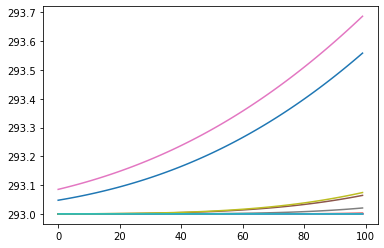

In [390]:
(states,act,rew,done,next_states) = model.agent.replay_buffer.sample(10)
plt.plot(states.T)
act,rew

In [371]:
env.reset()
d = deque([env.observe()]*100,maxlen=100)
model(torch.tensor(d)).argmax()

tensor(0)

In [325]:
model.env.he.data[model.env.he.target_index]

293.0